In [2]:
from langchain.tools import tool
from langchain.chat_models import init_chat_model
import redis
from qdrant_client import QdrantClient
from qdrant_client.models import Distance, VectorParams, PointStruct, Filter, FieldCondition, MatchValue
from pymongo import MongoClient
from sentence_transformers import SentenceTransformer

c:\Users\HP\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
pip install -U langchain-openai sentence-transformers


Note: you may need to restart the kernel to use updated packages.


In [4]:
from langchain_openai import ChatOpenAI
import os
from dotenv import load_dotenv
load_dotenv()
llm = ChatOpenAI(model="gpt-4", temperature=0,openai_api_key= os.getenv("OPENAI_API_KEY"))
from sentence_transformers import SentenceTransformer

# This MUST be named 'embedder' to match your function
embedder = SentenceTransformer('all-MiniLM-L6-v2') 

# Also ensure EMBEDDING_DIM matches the model (384 for this model)
EMBEDDING_DIM = 384

In [5]:
@tool
def multiply(a: int, b: int) -> int:
    """Multiply `a` and `b`.

    Args:
        a: First int
        b: Second int
    """
    return a * b


@tool
def add(a: int, b: int) -> int:
    """Adds `a` and `b`.

    Args:
        a: First int
        b: Second int
    """
    return a + b


@tool
def divide(a: int, b: int) -> float:
    """Divide `a` and `b`.

    Args:
        a: First int
        b: Second int
    """
    return a / b


tools = [add, multiply, divide]
tools_by_name = {tool.name: tool for tool in tools}
model_with_tools = llm.bind_tools(tools)

In [6]:
from langchain.messages import AnyMessage
from typing_extensions import TypedDict, Annotated
import operator




class AgentState(TypedDict):
    """State that flows through our agent graph."""
    messages: Annotated[list[AnyMessage],operator.add]
    user_message: str
    user_id: str
    session_id: str
    working_memory: dict
    episodic_context: list
    semantic_context: list
    procedural_context: list
    next_memory_step: str
    response: str

In [7]:
from langchain.messages import SystemMessage


def llm_call(state: dict):
    """LLM decides whether to call a tool or not"""

    return {
        "messages": [
            model_with_tools.invoke(
                [
                    SystemMessage(
                        content="you are helpful assistant ttasked with performing arithmetic on a set of inputs. "
                    )
                ]
                + state["messages"]
            )
        ],
        "llm_calls": state.get('llm_calls', 0) + 1
    }

In [8]:
from langchain.messages import ToolMessage


def tool_node(state: dict):
    """Performs the tool call"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}

In [9]:
from typing import Literal
from langgraph.graph import StateGraph, START, END


def should_continue(state: AgentState) -> Literal["tool_node", END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]

    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "tool_node"

    # Otherwise, we stop (reply to the user)
    return END

In [10]:
REDIS_URL = "redis://localhost:6379"
QDRANT_URL = "http://localhost:6333"
MONGODB_URL = "mongodb://localhost:27017"

# Initialize clients
redis_client = redis.from_url(REDIS_URL, decode_responses=True)
qdrant_client = QdrantClient(url=QDRANT_URL)
mongo_client = MongoClient(MONGODB_URL)
mongo_db = mongo_client["agent_memory"]

In [11]:
import json
from datetime import datetime, timedelta
from uuid import uuid4


In [12]:
@tool
def working_memory(session_id: str, key: str, value: dict, ttl: int = 300):
    """
    Store something in working memory.
    
    Args:
        session_id: Unique session identifier
        key: What we're storing (e.g., "current_goal", "user_intent")
        value: The data to store
        ttl: Time-to-live in seconds (default 5 minutes)
    """
    redis_key = f"wm:{session_id}:{key}"
    redis_client.setex(redis_key, ttl, json.dumps(value))


@tool
def episodic_memory(user_id: str, content: str, summary: str, metadata: dict = None):
    """
    Store an episode (experience/interaction).
    
    Args:
        user_id: Who this memory belongs to
        content: Full content of the interaction
        summary: Brief summary for context
        metadata: Additional info (topics, sentiment, etc.)
    """
    collections = [c.name for c in qdrant_client.get_collections().collections]
    
    if "episodic_memory" not in collections:
        qdrant_client.create_collection(
            collection_name="episodic_memory",
            vectors_config=VectorParams(size=EMBEDDING_DIM, distance=Distance.COSINE)
        )
        print("✓ Created episodic_memory collection")
    # Generate embedding from content
    embedding = embedder.encode(f"{summary} {content}").tolist()
    
    # Create unique ID
    point_id = uuid4().hex
    
    # Build payload
    payload = {
        "user_id": user_id,
        "content": content,
        "summary": summary,
        "timestamp": datetime.utcnow().isoformat(),
        "episode_id": point_id,
        **(metadata or {})
    }
    
    # Store in Qdrant
    qdrant_client.upsert(
        collection_name="episodic_memory",
        points=[PointStruct(id=point_id, vector=embedding, payload=payload)]
    )
    
    return point_id


@tool
def semantic_memory(user_id: str, concept: str, definition: str, metadata: dict = None):
    """
    Store a general fact or user preference.
    
    Args:
        user_id: Who this fact belongs to
        concept: The subject (e.g., "Favorite Color", "Python Coding Style")
        definition: The detail (e.g., "Likes blue", "Prefers functional programming")
        metadata: Categories like 'preference', 'fact', or 'rule'
    """
    collections = [c.name for c in qdrant_client.get_collections().collections]
    
    if "semantic_memory" not in collections:
        qdrant_client.create_collection(
            collection_name="semantic_memory",
            vectors_config=VectorParams(size=EMBEDDING_DIM, distance=Distance.COSINE)
        )

    # We encode the concept and definition together for semantic retrieval
    text_to_embed = f"{concept}: {definition}"
    embedding = embedder.encode(text_to_embed).tolist()
    
    payload = {
        "user_id": user_id,
        "concept": concept,
        "definition": definition,
        "type": "fact",
        "last_verified": datetime.utcnow().isoformat(),
        **(metadata or {})
    }

    # Store in Qdrant with a unique ID based on the concept to allow easy updates
    point_id = uuid4().hex
    qdrant_client.upsert(
        collection_name="semantic_memory",
        points=[PointStruct(id=point_id, vector=embedding, payload=payload)]
    )
    
    return point_id


tools = [working_memory, episodic_memory, semantic_memory]
tools_by_name = {tool.name: tool for tool in tools}
model_with_tools = llm.bind_tools(tools)

In [13]:
from typing import Literal
from pydantic import BaseModel, Field
from langchain_core.messages import SystemMessage

# Define the structure for the LLM's decision
class MemoryRoute(BaseModel):
    step: Literal["working", "episodic", "semantic"] = Field(
        description="The type of memory to access based on user intent."
    )

def memory_manager(state: dict):
    """
    LLM Node that decides which memory store to query.
    """
    
    # Bind the structured output to the model
    router_model = llm.with_structured_output(MemoryRoute)
    
    system_prompt = SystemMessage(
        content=(
            "You are a Memory Manager. Analyze the user's message and decide "
            "where to retrieve information from:\n"
            "- 'working': For info in the current conversation thread.\n"
            "- 'episodic': For specific past interactions or sessions.\n"
            "- 'semantic': For general knowledge, facts, or permanent user preferences."
            "-'working': Use for greetings, casual chat, or questions about the immediate conversation"
            "(e.g., 'hi', 'how are you?', 'what did I just say?')."
            "'episodic': Use ONLY if the user asks about specific past events, previous dates, or 'what we talked about before'."
            "'semantic': Use ONLY for general facts, rules, or permanent preferences (e.g., 'I am a vegetarian')."
        )
    )
    
    # The LLM call
    decision = router_model.invoke([system_prompt] + state["messages"])
    # DEBUG: See what the AI decided in real-time
    print(f"--- MEMORY MANAGER DECISION: {decision.step.upper()} ---")
    
    # Return the decision so the Graph can route the next step
    return {
        "next_memory_step": decision.step,
        "llm_calls": state.get('llm_calls', 0) + 1
    }

In [14]:
def route_memory(state: AgentState):
    # Use .get() to avoid the KeyError if the node failed to return it
    step = state.get("next_memory_step")
    
    if not step:
        # Fallback to a default node if something went wrong
        return "llm_call"
        
    return step

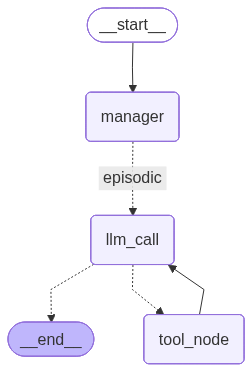

--- MEMORY MANAGER DECISION: WORKING ---
================================ Human Message =================================

hii
================================== Ai Message ==================================

Hello! How can I assist you today?


In [23]:
# Build workflow
agent_builder = StateGraph(AgentState)
def route_memory(state: AgentState):
    # This matches the key returned in your memory_manager node
    return state["next_memory_step"]

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("tool_node", tool_node)
agent_builder.add_node("manager",memory_manager)


# Add edges to connect nodes
agent_builder.add_edge(START, "manager")
agent_builder.add_conditional_edges(
    "manager",
    route_memory,
    {
        "working": "llm_call",    # Direct to LLM if it's just current context
        "episodic": "llm_call",  # Go to tools to fetch past history
        "semantic": "llm_call"   # Go to tools to fetch facts
    }
)

agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    ["tool_node", END]
)
agent_builder.add_edge("tool_node", "llm_call")

# Compile the agent
agent = agent_builder.compile()

# Show the agent
from IPython.display import Image, display
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

# Invoke
from langchain.messages import HumanMessage
messages = [HumanMessage(content="hii")]
messages = agent.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()